In [1]:
import numpy as np
import os

# Define the path to the first test data file
file_path = os.path.join('..', 'data', 'clusters_cleaned', 'test', 'data_test_set_cluster_0.npz')

# Load the .npz file
data = np.load(file_path, allow_pickle=True)

# See what arrays are stored in the file
print(f"Keys in the .npz file: {data.files}")

# Get the images and boxes arrays
images = data['images']
boxes = data['boxes']

# Print their shapes to understand the dimensions
print(f"Shape of the images array: {images.shape}")
print(f"Shape of the boxes array: {boxes.shape}")

Keys in the .npz file: ['images', 'boxes']
Shape of the images array: (448, 295, 295, 3)
Shape of the boxes array: (448,)


This output tells us the file is a container holding two arrays: images and boxes.

The images array contains 448 images, where each image is a 295x295 pixel color photo (the 3 stands for RGB channels).

The boxes array has 448 elements, one for each image. Each element contains all the bounding box labels for its corresponding image. It's structured this way because the number of champions on the minimap changes from frame to frame.

In [2]:
# Inspect the first image and its labels
first_image_boxes = boxes[0]

print(f"Shape of the box data for the first image: {first_image_boxes.shape}")
print("\nBox data for the first image:")
print(first_image_boxes)

Shape of the box data for the first image: (7, 5)

Box data for the first image:
[[ 15  37  32  67  62]
 [ 12 137 228 167 258]
 [ 20 121 127 151 157]
 [ 16 197 250 227 280]
 [ 32 203 249 233 279]
 [  9 214 244 244 274]
 [  4 200 236 230 266]]


This means that for the first image in our dataset, there are 7 champions detected on the minimap.

Each of the 7 rows represents one champion's bounding box. The 5 columns follow the format: [class_id, x_min, y_min, x_max, y_max].

For example, the first row [15 37 32 67 62] corresponds to a champion with class ID 15. Its bounding box is a rectangle with its top-left corner at pixel coordinates (37, 32) and its bottom-right corner at (67, 62).

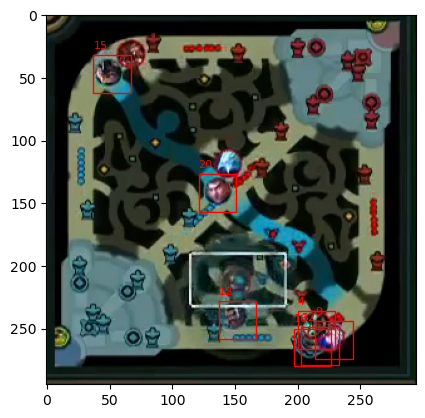

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the first image
first_image = images[0]

# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(first_image)

# Add the bounding boxes
for box in first_image_boxes:
    class_id, x_min, y_min, x_max, y_max = box
    
    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min
    
    # Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    # Add class ID text
    plt.text(x_min, y_min - 5, str(class_id), color='red', fontsize=8)

plt.show()

1. Why do we have these boxes and what are they for?

These red boxes are our ground truth labels. They are the "correct answers" that we will use to teach our neural network.

Think of it like this: We want to train a model to find champions. We show it an image of the minimap and ask, "Where are the champions?" The model makes a guess by drawing its own boxes. We then compare the model's guessed boxes to these perfect red boxes. If the model's guess is very close to a red box, we tell it "Good job." If it's far off, we tell it "Bad guess, try again." After doing this thousands of times, the model learns to draw accurate boxes on its own.

So, these boxes are the single most important part of our data. They are the target we are training our model to hit.

2. Where do they come from?

The creator of this dataset was very clever. They didn't draw these boxes by hand. They used the official game data from League of Legends, which provides the exact (x, y) coordinates of every champion at every second. They wrote scripts that automatically synced this coordinate data with the video frames to generate these perfect labels.

3. Why aren't all champions boxed?

This is a fantastic and critical observation. You've spotted a key feature of real-world datasets: they are almost never perfect.

The most likely reason is that the automated script used to generate these labels failed for those specific champions in this frame. This could be a bug in the code, a temporary glitch in the game data, or—very likely—those un-boxed champions are not among the 56 specific champions the creator decided to include in the dataset. The script was programmed to simply ignore any champion it didn't have a class ID for.

This is not a problem for us; in fact, it's an opportunity. Part of our project will be to analyze how these "missing labels" might affect the model's performance. For now, we've confirmed the data is what we expected: images paired with bounding box coordinates.

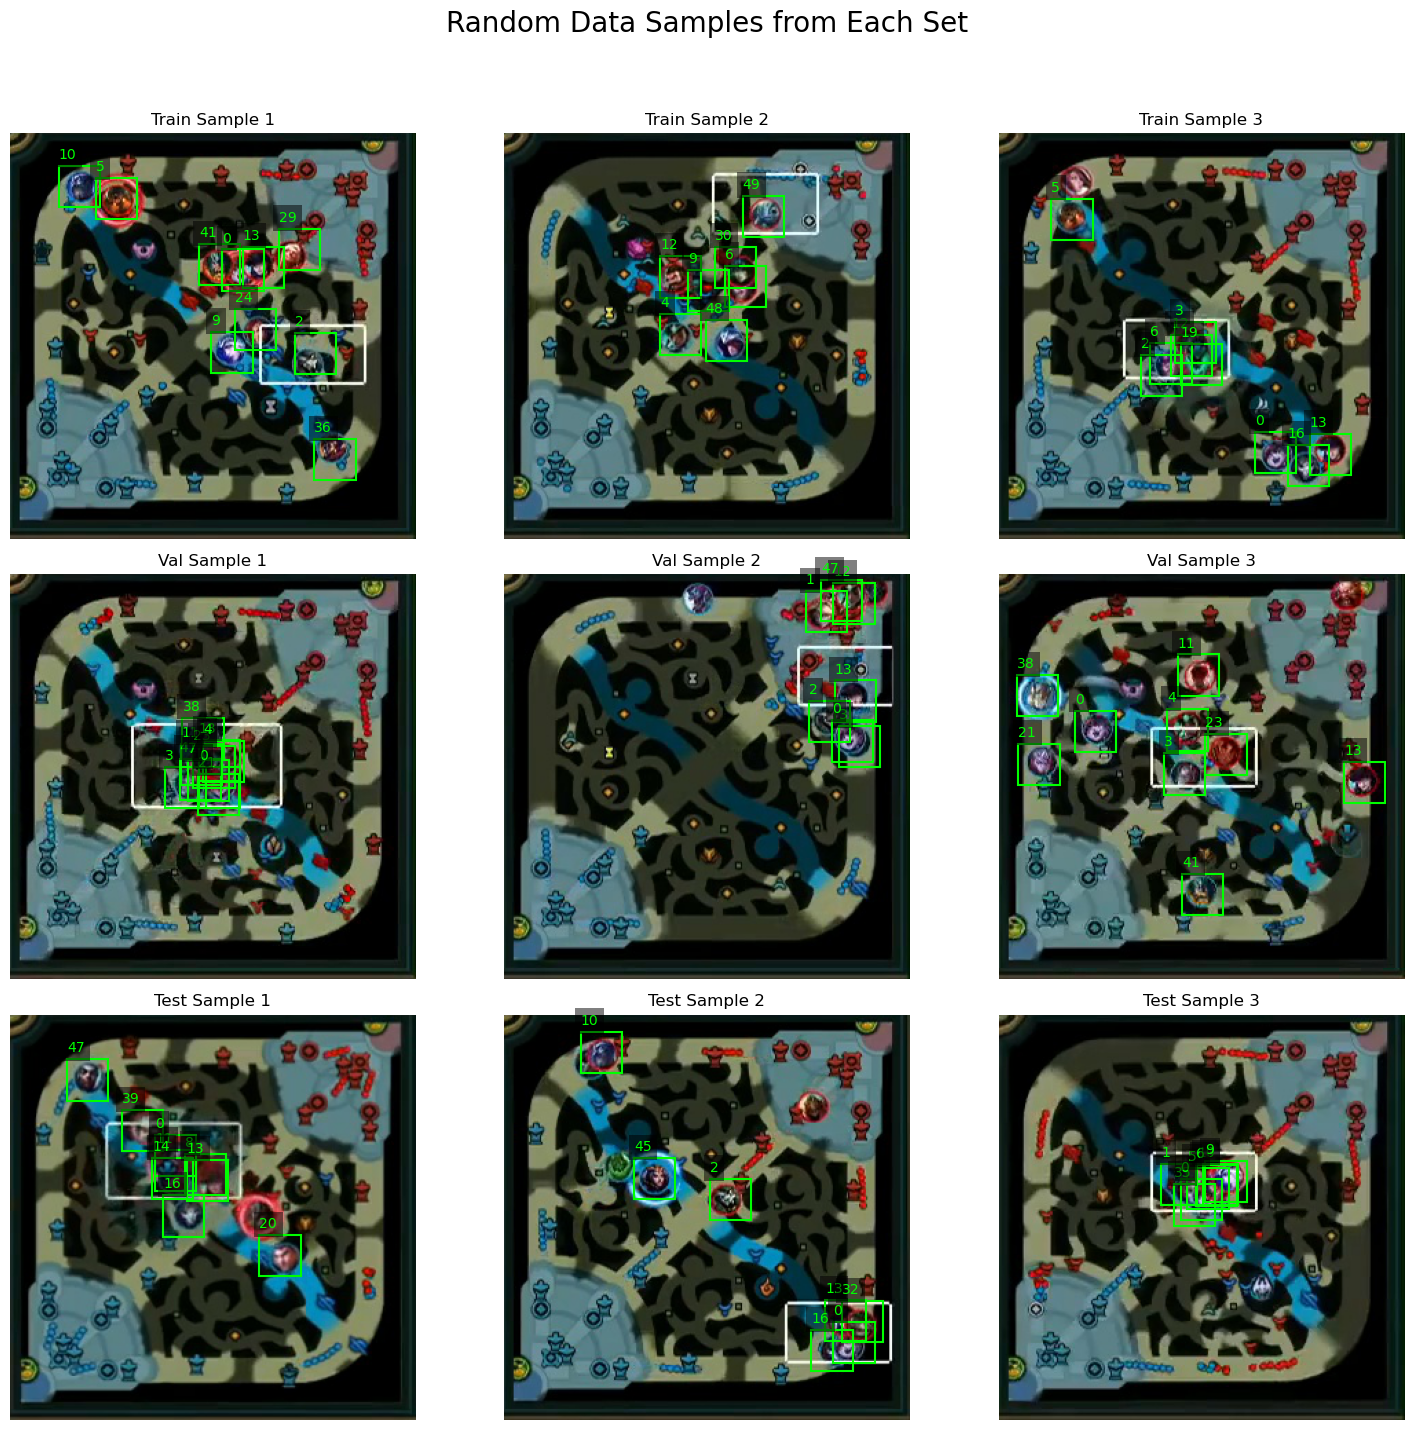

In [4]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_samples_from_split(split_name, num_samples, base_path, fig_axes):
    """Picks a random npz file from a split and plots random samples from it."""
    
    split_path = os.path.join(base_path, split_name)
    
    # Get a list of all cluster files in the directory
    cluster_files = [f for f in os.listdir(split_path) if f.endswith('.npz')]
    
    if not cluster_files:
        print(f"No .npz files found in {split_path}")
        return
        
    # Pick one random cluster file to sample from
    random_cluster_file = random.choice(cluster_files)
    file_path = os.path.join(split_path, random_cluster_file)
    
    # Load the data
    data = np.load(file_path, allow_pickle=True)
    images = data['images']
    boxes = data['boxes']
    
    # Get random indices for the images to plot
    num_images_in_file = images.shape[0]
    sample_indices = random.sample(range(num_images_in_file), num_samples)
    
    # Plot each sample
    for i, img_index in enumerate(sample_indices):
        ax = fig_axes[i]
        image = images[img_index]
        image_boxes = boxes[img_index]
        
        ax.imshow(image)
        ax.set_title(f"{split_name.capitalize()} Sample {i+1}")
        ax.axis('off') # Hide the axes
        
        # Draw bounding boxes on the image
        for box in image_boxes:
            class_id, x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, str(class_id), color='lime', fontsize=10, bbox=dict(facecolor='black', alpha=0.5, lw=0))

# --- Main script ---
base_data_path = os.path.join('..', 'data', 'clusters_cleaned')
splits_to_show = ['train', 'val', 'test']
samples_per_split = 3

# Create a figure with subplots in a grid
fig, axes = plt.subplots(len(splits_to_show), samples_per_split, figsize=(15, 15))
fig.suptitle('Random Data Samples from Each Set', fontsize=20)

for i, split in enumerate(splits_to_show):
    plot_samples_from_split(split, samples_per_split, base_data_path, axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()